In [1]:
# saves you having to use print as all exposed variables are printed in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime

# matpolitlib config
%matplotlib inline
plt.rcParams['figure.figsize'] = 12,4

# suppress warning message
import warnings
warnings.filterwarnings('ignore')

%reload_ext autoreload
%autoreload 2

import ds_discovery
import ds_behavioral
print('DTU: {}'.format(ds_discovery.__version__))
print('DBU: {}'.format(ds_behavioral.__version__))

DTU: 1.07.020
DBU: 1.00.030


In [2]:
from ds_behavioral import DataBuilder
from ds_discovery.transition.cleaners import ColumnCleaners as cleaner
from ds_discovery.transition.discovery import DataDiscovery as discovery

# Correlation
From a series or list of numbers, dates or categories alows the creation or a correlated list.

In [3]:
builder = DataBuilder('correlation')
tools = builder.tools


----

### Buildng a profile
Before we start lets consider a common requirement of building a profile base of names and addresses. 

We can build profiles in lots of ways but there are two built in methods that allow you to create profies quickly, then drop columns you might not need or want.

firstly the methof `get_profiles` returns a gender specific set of random names 

In [7]:
tools.get_profiles(size=5)

,surname,forename,gender
0,Foppiano,Beatrix,F
1,Munshi,Arun,M
2,Chananie,Cletus,M
3,Vandresar,Dylan,M
4,Allgire,Vicky,F


By defualt the names are randomly split 50/50 M/F but you can tailor this with the use of the weighting parameter `mf_weighting`

In [8]:
sample_size = 100

df_customer = tools.get_profiles(size=sample_size, mf_weighting=[7,3])
df_customer['gender'].value_counts()

M    72
F    28
Name: gender, dtype: int64

----

### Correlating Gender to title
From this we can now correlate gender to a title. We are looking for 'M' to be 'Mr' and 'F' to be 'Mrs'

we can you the contextual help to see what to do


In [9]:
help(tools.correlate_categories)

Help on function correlate_categories in module ds_behavioral.generator.data_builder:

correlate_categories(values:Any, correlations:list, actions:dict, value_type:str, day_first:bool=True, quantity:float=None, seed:int=None)
    correlation of a set of values to an action, the correlations must map to the dictionary index values.
    Note. to use the current value in the passed values as a parameter value pass an empty dict {} as the keys
    value. If you want the action value to be the current value of the passed value then again pass an empty dict
    action to be the current value
        simple correlation list:
            ['A', 'B', 'C'] # if values is 'A' then action is 0 and so on
        multiple choice correlation
            [['A','B'], 'C'] # if values is 'A' OR 'B' then action is 0 and so on
        actions dictionary where the action is a class method name and kwargs its parameters
            {0: {'action': '', 'kwargs' : {}}, 1: {'action': '', 'kwargs' : {}}}
        

In [10]:
correlations = ['M', 'F']
actions = {0: {'action': 'Mr'}, 
           1: {'action': 'Mrs'}}

df_customer['title'] = tools.correlate_categories(df_customer['gender'], correlations=correlations, actions=actions, value_type='category')

When we look at the value count of the 'title' we can see it mirrors the 'gender'

In [11]:
df_customer['title'].value_counts()

Mr     72
Mrs    28
Name: title, dtype: int64

---

### Methods as actions
with actions, they don't have to be a one to one relationship to the values, we can also us our 'get_' methods to generate selected values.

In this next example we want there to be roughly 20% of the female gender to 'Miss' and roughly 10% 'Ms'. For this we will use the `get_category(...)` method and put it as our action value along with any kwargs for that method. Note you only give the method name and you don't specify size as a kwarg.

In [12]:
correlations = ['M', 'F']
actions = {0: {'action': 'Mr'}, 
           1: {'action': 'get_category', 'kwargs': {'selection' : ['Mrs', 'Miss', 'Ms'], 'weight_pattern': [5,3,1]}}}

df_customer['title'] = tools.correlate_categories(df_customer['gender'], correlations=correlations, actions=actions, value_type='category')

When we look at the value count of title again we can see our alternative 'Female' titles have been selectively distributes to the weighting

In [13]:
df_customer['title'].value_counts()

Mr      72
Mrs     14
Miss    11
Ms       3
Name: title, dtype: int64

----

### Finally lets save this file to disk as our Customer records

We need to generate an id for the customers then save.

In [14]:
df_customer['customer_id'] = tools.unique_identifiers(100, 999, size=sample_size)

In [16]:
builder.save_to_disk(df_customer, filename='customer.csv', path='./')

----

## Correlating across files

Let us now consider we have a new file, such as `Accounts` and 
- we want to correlate the customer_id with the account.
- correlate an account balance with interest paid

To show how we do this lest first build a simple accounts DataFrame

In [17]:
df_accounts = pd.DataFrame()
df_accounts['account_id'] = tools.unique_identifiers(1000, 2000, size=150)

# Create a weighting pattern that is loaded towards low value and then exponetially tails off
value_distribution = [0.01,0.8,1,3,9,8,3,2,1] + list(np.flip(np.exp(np.arange(-5,0.0, 0.2)).round(2)))

# Apply the weighting to an account range of 0 to 1000
df_accounts['balance'] = tools.get_number(0, 1000, weight_pattern=value_distribution, size=150)


-----
### Correlate Numbers
We want to correlate the account value with interest paid, say 2%, therefore:
- the 'spread' will be zero as we don't want any variance
- an 'offset' of 0.02 of the balance with a 'action' of 'multiply'
- set the precision to 2


In [18]:
df_accounts['interest'] = tools.correlate_numbers(df_accounts['balance'], spread=0, offset=0.02, action='multiply', precision=2)

now when we look at the correlation between the interest and the balance we see that direct correlation

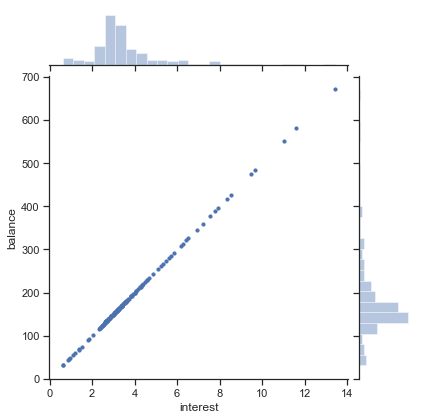

In [19]:
sns.set(style="ticks", color_codes=True)
g = sns.jointplot(x='interest',y='balance',data=df_accounts, s=10)

-----
### Correlate Account with Customer

in order to create the relationsip we need to get the `account_id` from the `customer` file and then correlate them with the account_id

to do this we use `get_reference` method

In [21]:
df_accounts['customer_id'] = tools.get_reference(header='customer_id', filename='customer.csv', size=150)

In [22]:
df_accounts.head(3)

,account_id,balance,interest,customer_id
0,1540,326,6.52,338
1,1029,131,2.62,893
2,1031,156,3.12,652


We now have `account_id` correlated to the `customer_id` from the `customer` file

But when we look at the results we have customers will multiple account

In [23]:
df_accounts['customer_id'].value_counts().unique()

array([5, 3, 2, 1])

In [24]:
df_accounts['customer_id'].value_counts().value_counts()

1    39
2    30
3    12
5     3
Name: customer_id, dtype: int64

----

### Advanced correlation of identifers across files

lets see what the method offeres us with the contextual help

In [25]:
help(tools.get_reference)

Help on function get_reference in module ds_behavioral.generator.data_builder:

get_reference(header:str, filename:str, weight_pattern:list=None, selection_size:int=None, sample_size:int=None, size:int=None, at_most:bool=None, shuffled:bool=True, file_format:str=None, quantity:float=None, seed:int=None, **kwargs)
    :param header: the name of the header to be selected from
    :param filename: the full path and filename to be loaded
    :param weight_pattern: (optional) a weighting pattern of the final selection
    :param selection_size: (optional) the selection to take from the sample size, norally used with shuffle
    :param sample_size: (optional) the size of the sample to take from the reference file
    :param at_most: (optional) the most times a selection should be chosen
    :param shuffled: (optional) if the selection should be shuffled before selection. Default is true
    :param file_format: (optional) the format of the file to reference
    :param quantity: (optional) a n

In this instance the option we are most interested in is the **at_most** option to set the most number of cutomer_id's that can be chosen overall

In [27]:
df_accounts['customer_id'] = tools.get_reference('customer_id', filename='customer.csv', at_most=2, size=150)

Now when we look at the account ditribution we can see we have 1 or 2 accounts only

In [28]:
df_accounts['customer_id'].value_counts().unique()

array([2, 1])

In [29]:
df_accounts['customer_id'].value_counts().value_counts()

2    64
1    22
Name: customer_id, dtype: int64

Job Done!!

Have an explore of the other options too, Use:
- **sample_size** if you have a large file or you want to shuffle a larger set before selecting a subset of that
- **selection_size** to only have a subset of the load size to select from. Mostly used with shuffle
- **at_most** we have seen to restrict the max count of selections
- **weighting_pattern** can be used for advanced filtering and time series selections were you don't want certain cutomers at certain times.